In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from tqdm import tqdm
import random

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet(BasicBlock, [2, 2, 2, 2])
net = net.to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [5]:
train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32, padding=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])
test_transform = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], 
                                                std = [0.2023, 0.1994, 0.2010])
                       ])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


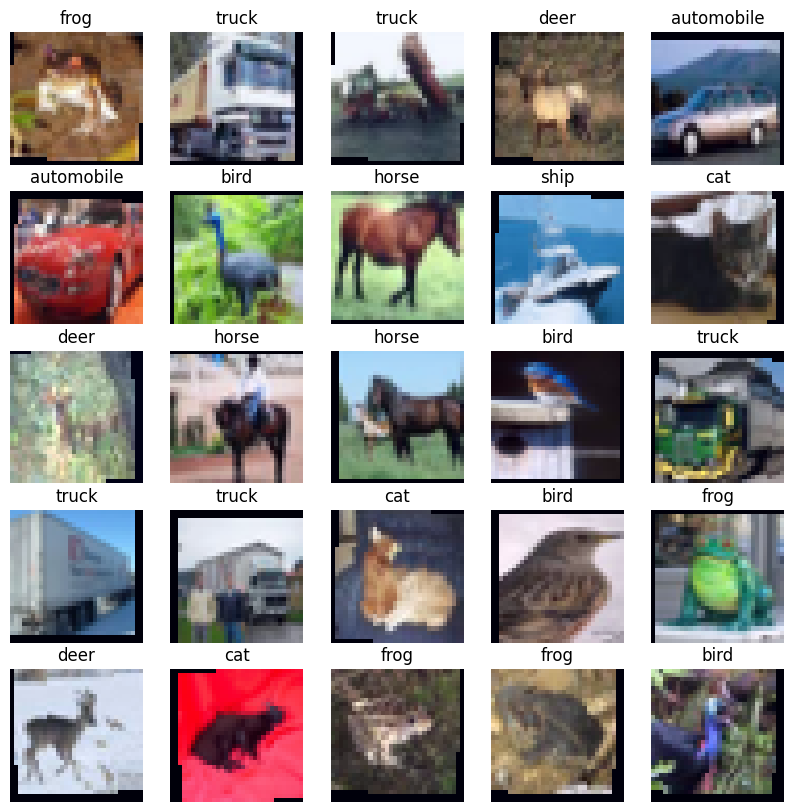

In [6]:
def plot_images(images, labels, classes, normalize = False):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (10, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)       
        image = images[i]
        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in [train_dataset[i] for i in range(N_IMAGES)]])
classes = test_dataset.classes
plot_images(images, labels, classes, normalize = True)

In [7]:
def train(data_loader, model, criterion, optimizer, scheduler=None, early_stop=None):
    learning_rate_tracker = {}
    epoch_correct = 0
    running_loss = 0.0
    model.train()
    
    # Wrapping the enumerator with tqdm for progress bar
    for i, (images, labels) in tqdm(enumerate(data_loader), total=len(data_loader), desc="Training"):
        learning_rate_tracker[i] = optimizer.param_groups[0]['lr']
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels) 
        running_loss += loss.item()
        predicted = torch.max(outputs.data, 1)[1]
        epoch_correct += (predicted == labels).sum().item()
        
        if early_stop and i == early_stop:
            break
            
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

    return epoch_correct, running_loss, learning_rate_tracker
    
def evaluate(data_loader, model, criterion):
    epoch_correct = 0
    running_loss = 0.0
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels) 
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            epoch_correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    return epoch_correct, running_loss, y_true, y_pred

In [8]:
lr_min = 1e-6
lr_max = 1e-2
epochs = 30
step_size = (len(train_dataset)/64) // 2

model = net
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr_min, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr_min, max_lr=lr_max, step_size_up=step_size, step_size_down=step_size, gamma=0.9999, mode="exp_range", cycle_momentum=False)
lr_tracker = {}

train_loss_history_cuda = []
train_acc_history_cuda = []
val_loss_history_cuda = []
val_acc_history_cuda = []
y_pred_cuda = []
y_true_cuda = []
best_valid_loss = float('inf')

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}/{epochs}")
    correct, loss, rate_tracker = train(data_loader=train_loader, model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler)
    accuracy = correct / len(train_loader.dataset)
    loss = loss / len(train_loader)
    train_loss = loss
    train_acc_history_cuda.append(accuracy)
    train_loss_history_cuda.append(loss)
    for key in rate_tracker.keys():
        lr_tracker[(epoch,key)] = rate_tracker[key]
    correct, loss, y_true_cuda, y_pred_cuda = evaluate(data_loader = test_loader, model=model, criterion=criterion)
    validation_accuracy = correct / len(test_loader.dataset)
    validation_loss = loss / len(test_loader)
    print(f"Train Accuracy: {accuracy*100:.2f}%, Train Loss: {train_loss}")
    print(f"Test Accuracy: {validation_accuracy*100:.2f}%, Test Loss: {validation_loss}")
    # if validation_loss < best_valid_loss:
    #     best_valid_loss = validation_loss
    #     torch.save(model.state_dict(), 'ResNetCuda.pt')
    val_acc_history_cuda.append(validation_accuracy)
    val_loss_history_cuda.append(validation_loss)

Epoch: 1/30


Training: 100%|██████████| 782/782 [00:31<00:00, 24.79it/s]


Train Accuracy: 50.96%, Train Loss: 1.3492441140782192
Test Accuracy: 70.56%, Test Loss: 0.8256804529269031
Epoch: 2/30


Training: 100%|██████████| 782/782 [00:31<00:00, 25.19it/s]


Train Accuracy: 69.81%, Train Loss: 0.8539690242322815
Test Accuracy: 78.63%, Test Loss: 0.6085059564964027
Epoch: 3/30


Training: 100%|██████████| 782/782 [00:31<00:00, 25.08it/s]


Train Accuracy: 76.30%, Train Loss: 0.6802003127153572
Test Accuracy: 81.83%, Test Loss: 0.5299245831882877
Epoch: 4/30


Training: 100%|██████████| 782/782 [00:31<00:00, 25.08it/s]


Train Accuracy: 79.71%, Train Loss: 0.5748834445920137
Test Accuracy: 83.72%, Test Loss: 0.4771218865540377
Epoch: 5/30


Training: 100%|██████████| 782/782 [00:31<00:00, 25.22it/s]


Train Accuracy: 82.03%, Train Loss: 0.5130514947845198
Test Accuracy: 85.18%, Test Loss: 0.4298126465006239
Epoch: 6/30


Training: 100%|██████████| 782/782 [00:31<00:00, 24.80it/s]


Train Accuracy: 84.06%, Train Loss: 0.46005493301488554
Test Accuracy: 86.00%, Test Loss: 0.4128311882922604
Epoch: 7/30


Training: 100%|██████████| 782/782 [00:31<00:00, 24.69it/s]


Train Accuracy: 85.45%, Train Loss: 0.4215645599548164
Test Accuracy: 86.79%, Test Loss: 0.38661172288428447
Epoch: 8/30


Training: 100%|██████████| 782/782 [00:31<00:00, 25.04it/s]


Train Accuracy: 86.77%, Train Loss: 0.38589437829945095
Test Accuracy: 87.21%, Test Loss: 0.3786169920757318
Epoch: 9/30


Training: 100%|██████████| 782/782 [00:31<00:00, 25.11it/s]


Train Accuracy: 87.74%, Train Loss: 0.35397665336004
Test Accuracy: 88.15%, Test Loss: 0.3566425275176194
Epoch: 10/30


Training: 100%|██████████| 782/782 [00:31<00:00, 25.05it/s]


Train Accuracy: 88.81%, Train Loss: 0.32647819497891706
Test Accuracy: 88.24%, Test Loss: 0.3460169208182651
Epoch: 11/30


Training: 100%|██████████| 782/782 [00:31<00:00, 24.99it/s]


Train Accuracy: 89.64%, Train Loss: 0.30190454303379866
Test Accuracy: 88.63%, Test Loss: 0.33812456900716586
Epoch: 12/30


Training: 100%|██████████| 782/782 [00:31<00:00, 25.09it/s]


Train Accuracy: 90.06%, Train Loss: 0.28174953596175784
Test Accuracy: 89.16%, Test Loss: 0.3269184235554592
Epoch: 13/30


Training: 100%|██████████| 782/782 [00:30<00:00, 25.26it/s]


Train Accuracy: 90.75%, Train Loss: 0.26578617155971124
Test Accuracy: 89.31%, Test Loss: 0.316772208756702
Epoch: 14/30


Training: 100%|██████████| 782/782 [00:32<00:00, 24.44it/s]


Train Accuracy: 91.60%, Train Loss: 0.24594811998936525
Test Accuracy: 89.42%, Test Loss: 0.31674831009404675
Epoch: 15/30


Training: 100%|██████████| 782/782 [00:32<00:00, 23.88it/s]


Train Accuracy: 92.06%, Train Loss: 0.2278870582828284
Test Accuracy: 89.59%, Test Loss: 0.3111345316906264
Epoch: 16/30


Training: 100%|██████████| 782/782 [00:32<00:00, 23.99it/s]


Train Accuracy: 92.61%, Train Loss: 0.21160271914337603
Test Accuracy: 89.81%, Test Loss: 0.3125010557520162
Epoch: 17/30


Training: 100%|██████████| 782/782 [00:32<00:00, 24.35it/s]


Train Accuracy: 93.04%, Train Loss: 0.19795721081916787
Test Accuracy: 90.34%, Test Loss: 0.30821007912515835
Epoch: 18/30


Training: 100%|██████████| 782/782 [00:31<00:00, 24.75it/s]


Train Accuracy: 93.52%, Train Loss: 0.18553531784421343
Test Accuracy: 90.18%, Test Loss: 0.301646624970588
Epoch: 19/30


Training: 100%|██████████| 782/782 [00:35<00:00, 22.10it/s]


Train Accuracy: 94.00%, Train Loss: 0.17463462068068097
Test Accuracy: 90.42%, Test Loss: 0.2976793464581678
Epoch: 20/30


Training: 100%|██████████| 782/782 [00:32<00:00, 24.05it/s]


Train Accuracy: 94.49%, Train Loss: 0.15974515350178228
Test Accuracy: 90.61%, Test Loss: 0.29985719890731155
Epoch: 21/30


Training: 100%|██████████| 782/782 [00:31<00:00, 24.82it/s]


Train Accuracy: 94.93%, Train Loss: 0.1484225428951404
Test Accuracy: 90.43%, Test Loss: 0.2987126267639695
Epoch: 22/30


Training: 100%|██████████| 782/782 [00:31<00:00, 24.89it/s]


Train Accuracy: 95.12%, Train Loss: 0.14049970148288457
Test Accuracy: 90.77%, Test Loss: 0.30240117440557784
Epoch: 23/30


Training: 100%|██████████| 782/782 [00:30<00:00, 25.34it/s]


Train Accuracy: 95.40%, Train Loss: 0.13276922414817696
Test Accuracy: 90.85%, Test Loss: 0.3031622923341147
Epoch: 24/30


Training: 100%|██████████| 782/782 [00:31<00:00, 25.17it/s]


Train Accuracy: 95.61%, Train Loss: 0.1262977461180533
Test Accuracy: 90.82%, Test Loss: 0.30150414661617037
Epoch: 25/30


Training: 100%|██████████| 782/782 [00:30<00:00, 25.27it/s]


Train Accuracy: 95.98%, Train Loss: 0.1159470077708859
Test Accuracy: 90.98%, Test Loss: 0.3014162451171192
Epoch: 26/30


Training: 100%|██████████| 782/782 [00:31<00:00, 25.12it/s]


Train Accuracy: 96.29%, Train Loss: 0.10850186525698742
Test Accuracy: 91.03%, Test Loss: 0.30280438687201516
Epoch: 27/30


Training: 100%|██████████| 782/782 [00:31<00:00, 25.12it/s]


Train Accuracy: 96.47%, Train Loss: 0.10359148891009104
Test Accuracy: 91.05%, Test Loss: 0.30281330735250644
Epoch: 28/30


Training: 100%|██████████| 782/782 [00:31<00:00, 25.11it/s]


Train Accuracy: 96.65%, Train Loss: 0.09718082632626528
Test Accuracy: 91.15%, Test Loss: 0.30380231576265804
Epoch: 29/30


Training: 100%|██████████| 782/782 [00:31<00:00, 25.20it/s]


Train Accuracy: 96.97%, Train Loss: 0.08874734110244172
Test Accuracy: 91.02%, Test Loss: 0.3098286496368563
Epoch: 30/30


Training: 100%|██████████| 782/782 [00:31<00:00, 24.86it/s]


Train Accuracy: 97.02%, Train Loss: 0.08667154053864462
Test Accuracy: 90.78%, Test Loss: 0.30951927796860407


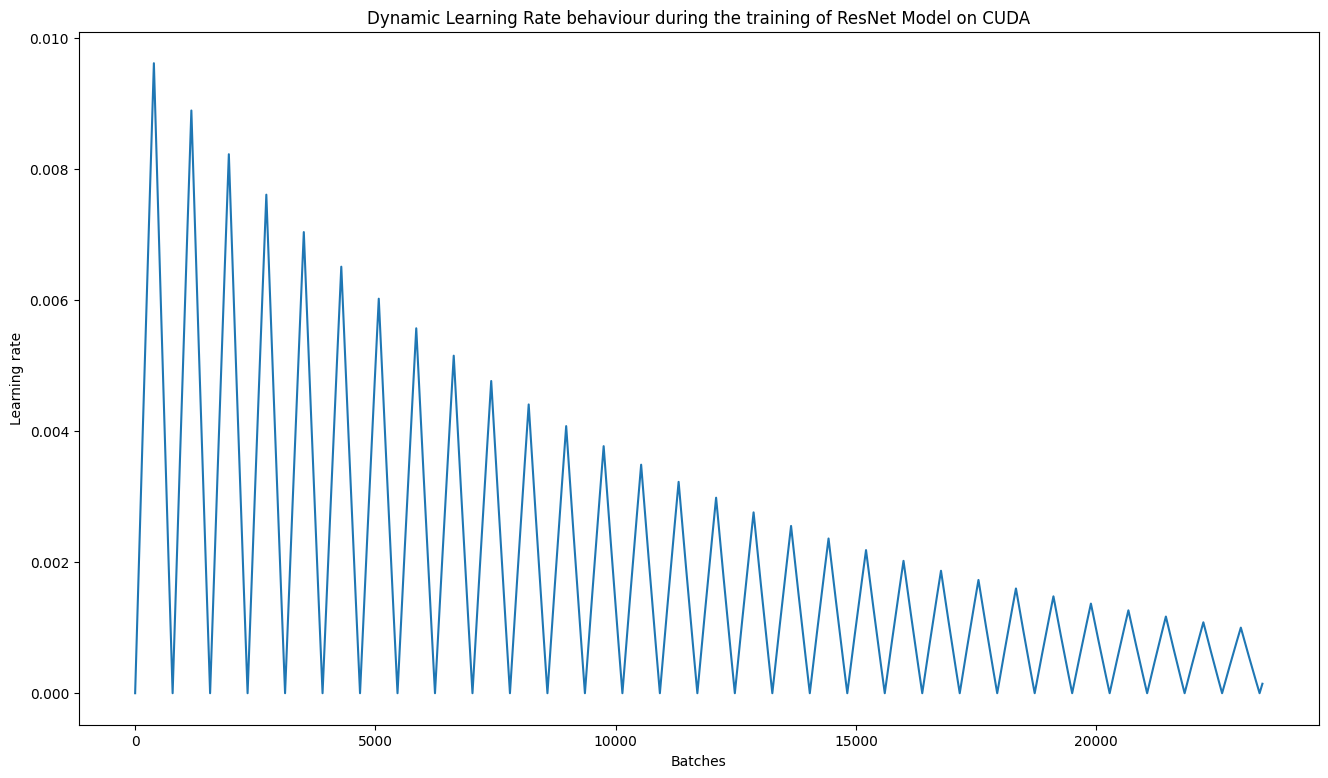

In [9]:
fig, ax = plt.subplots(figsize=(16,9))
plt.title('Dynamic Learning Rate behaviour during the training of ResNet Model on CUDA')
plt.plot(range(len(lr_tracker)), lr_tracker.values())
plt.xlabel('Batches')
plt.ylabel('Learning rate')
plt.savefig("Dynamic_LR_CUDA.png", format="png", dpi=300)
plt.show()

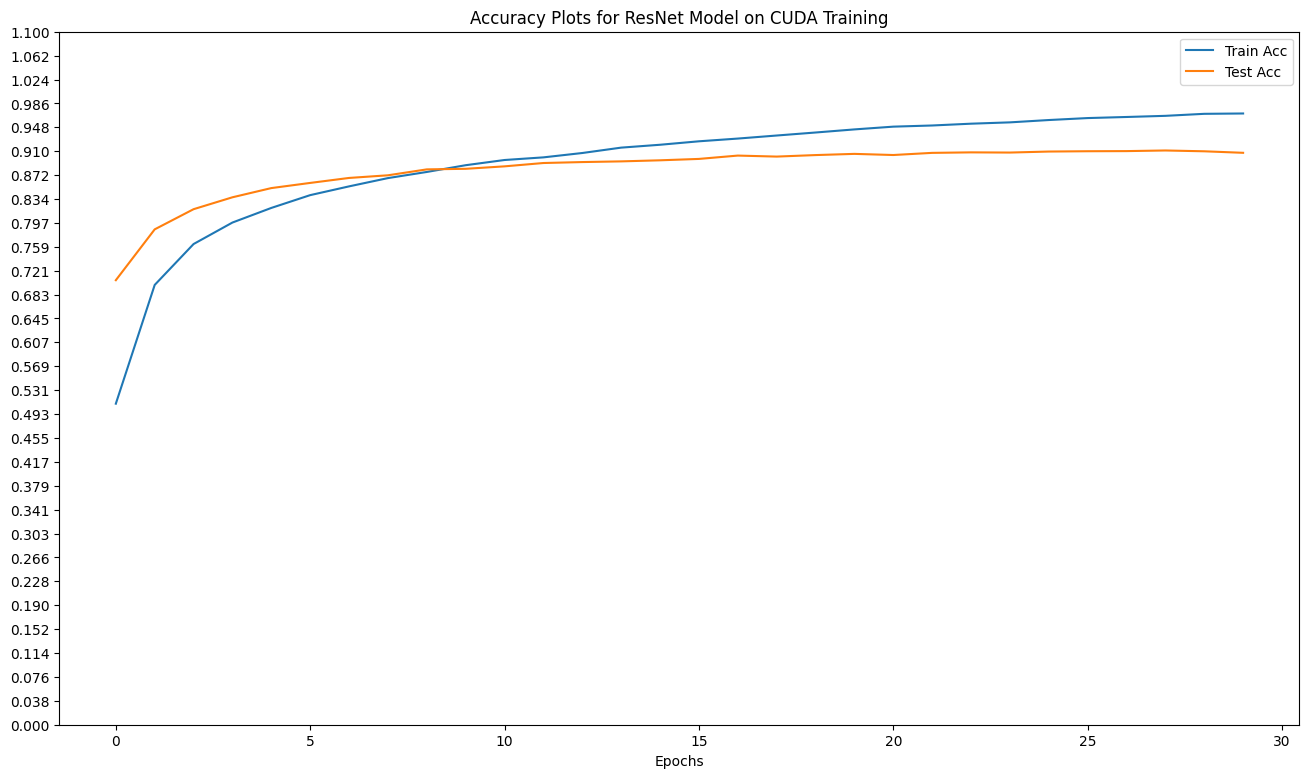

In [10]:
fig, ax = plt.subplots(figsize=(16,9))

plt.title('Accuracy Plots for ResNet Model on CUDA Training')
plt.plot(train_acc_history_cuda, label='Train Acc')  
plt.plot(val_acc_history_cuda, label='Test Acc')
plt.legend()
plt.xlabel("Epochs")
yticks = np.linspace(0, 1.1, num=30)
ax.set_yticks(yticks)
plt.savefig("Accuracy_CUDA.png", format="png", dpi=300)
plt.show()  

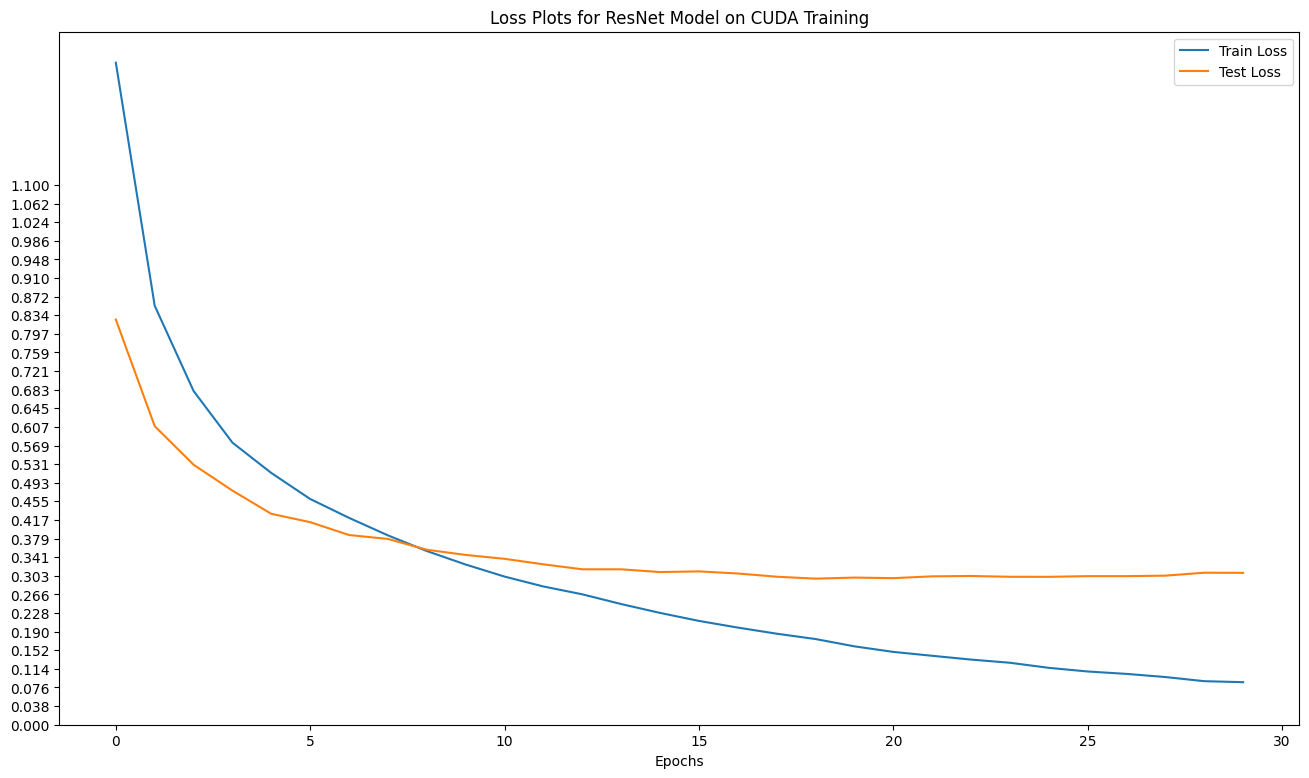

In [11]:
fig, ax = plt.subplots(figsize=(16,9))

plt.title('Loss Plots for ResNet Model on CUDA Training')
plt.plot(train_loss_history_cuda, label='Train Loss')
plt.plot(val_loss_history_cuda, label='Test Loss')
plt.legend()
plt.xlabel("Epochs")
yticks = np.linspace(0, 1.1, num=30)
ax.set_yticks(yticks)
plt.savefig("Loss_CUDA.png", format="png", dpi=300)
plt.show()  

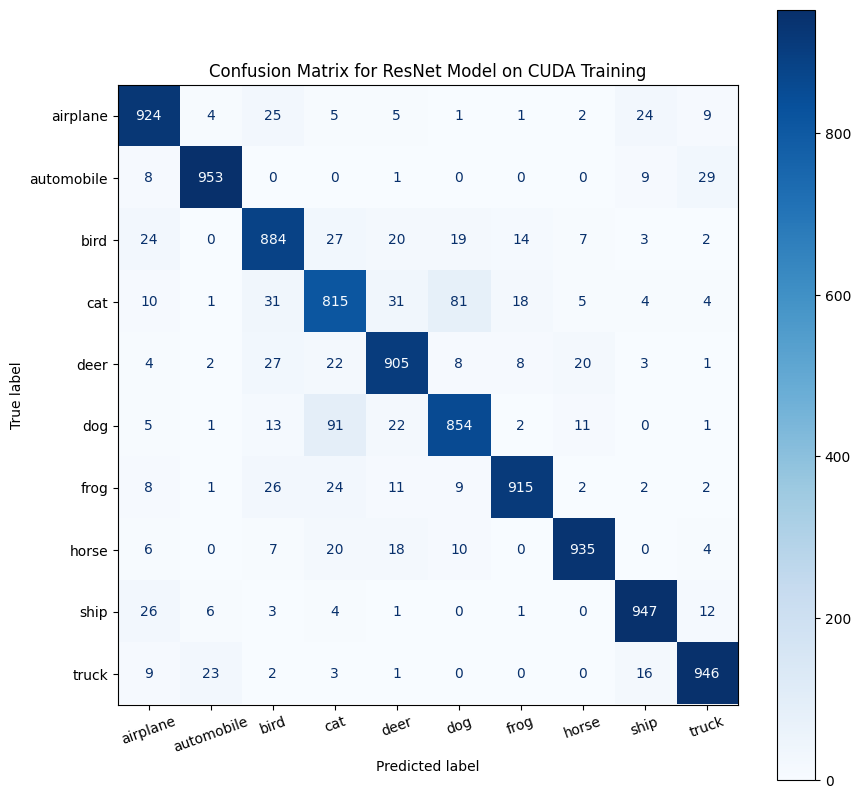

In [12]:
cm = confusion_matrix(y_true_cuda, y_pred_cuda)
fig = plt.figure(figsize = (10, 10));
ax = fig.add_subplot(1, 1, 1);
ax.set_title('Confusion Matrix for ResNet Model on CUDA Training')
cm = ConfusionMatrixDisplay(cm, display_labels = classes);
cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
plt.savefig("Confusion_CUDA.png", format="png", dpi=300)
plt.xticks(rotation = 20)
plt.show()  

In [13]:
import torch
from tqdm import tqdm

# Updated GradScaler initialization
scaler = torch.amp.GradScaler('cuda')

def train_tensor(data_loader, model, criterion, optimizer, scheduler=None, early_stop=None):
    learning_rate_tracker = {}
    epoch_correct = 0
    running_loss = 0.0
    model.train()

    for i, (images, labels) in tqdm(enumerate(data_loader), total=len(data_loader), desc="Training"):
        learning_rate_tracker[i] = optimizer.param_groups[0]['lr']
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Updated autocast context manager
        with torch.amp.autocast('cuda'):  
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        running_loss += loss.item()
        predicted = torch.max(outputs.data, 1)[1]
        epoch_correct += (predicted == labels).sum().item()
        
        if early_stop and i == early_stop:
            break

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if scheduler:
            scheduler.step()

    return epoch_correct, running_loss, learning_rate_tracker

def evaluate_tensor(data_loader, model, criterion):
    epoch_correct = 0
    running_loss = 0.0
    y_true = []
    y_pred = []
    model.eval()
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Updated autocast context manager
            with torch.amp.autocast('cuda'):  
                outputs = model(images)
                loss = criterion(outputs, labels)
                
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            epoch_correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    return epoch_correct, running_loss, y_true, y_pred


In [14]:
lr_min = 1e-6
lr_max = 1e-2
epochs = 30
step_size = (len(train_dataset)/64) // 2

model = net
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr_min, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr_min, max_lr=lr_max, step_size_up=step_size, step_size_down=step_size, gamma=0.9999, mode="exp_range", cycle_momentum=False)
lr_tracker = {}

train_loss_history_tensor = []
train_acc_history_tensor = []
val_loss_history_tensor = []
val_acc_history_tensor = []
y_pred_tensor = []
y_true_tensor = []
best_valid_loss = float('inf')

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}/{epochs}")
    correct, loss, rate_tracker = train_tensor(data_loader=train_loader, model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler)
    accuracy = correct / len(train_loader.dataset)
    loss = loss / len(train_loader)
    train_loss = loss
    train_acc_history_tensor.append(accuracy)
    train_loss_history_tensor.append(loss)
    for key in rate_tracker.keys():
        lr_tracker[(epoch,key)] = rate_tracker[key]
    correct, loss, y_true_tensor, y_pred_tensor = evaluate_tensor(data_loader = test_loader, model=model, criterion=criterion)
    validation_accuracy = correct / len(test_loader.dataset)
    validation_loss = loss / len(test_loader)
    print(f"Train Accuracy: {accuracy*100:.2f}%, Train Loss: {train_loss}")
    print(f"Test Accuracy: {validation_accuracy*100:.2f}%, Test Loss: {validation_loss}")
    # if validation_loss < best_valid_loss:
    #     best_valid_loss = validation_loss
    #     torch.save(model.state_dict(), 'ResNetMixed.pt')
    val_acc_history_tensor.append(validation_accuracy)
    val_loss_history_tensor.append(validation_loss)

Epoch: 1/30


Training: 100%|██████████| 782/782 [00:17<00:00, 44.40it/s]


Train Accuracy: 89.43%, Train Loss: 0.3051914146451084
Test Accuracy: 89.09%, Test Loss: 0.32367847266660377
Epoch: 2/30


Training: 100%|██████████| 782/782 [00:16<00:00, 46.02it/s]


Train Accuracy: 90.82%, Train Loss: 0.262114034832248
Test Accuracy: 90.01%, Test Loss: 0.3071380210625138
Epoch: 3/30


Training: 100%|██████████| 782/782 [00:16<00:00, 46.43it/s]


Train Accuracy: 91.76%, Train Loss: 0.2350994582952517
Test Accuracy: 90.33%, Test Loss: 0.2988962784504435
Epoch: 4/30


Training: 100%|██████████| 782/782 [00:16<00:00, 46.58it/s]


Train Accuracy: 92.76%, Train Loss: 0.2082935363921287
Test Accuracy: 90.30%, Test Loss: 0.2920851011280042
Epoch: 5/30


Training: 100%|██████████| 782/782 [00:16<00:00, 46.01it/s]


Train Accuracy: 93.19%, Train Loss: 0.19291624204848734
Test Accuracy: 90.70%, Test Loss: 0.28721983412838287
Epoch: 6/30


Training: 100%|██████████| 782/782 [00:16<00:00, 46.16it/s]


Train Accuracy: 93.92%, Train Loss: 0.17222251248119586
Test Accuracy: 90.89%, Test Loss: 0.2934662103652954
Epoch: 7/30


Training: 100%|██████████| 782/782 [00:17<00:00, 44.79it/s]


Train Accuracy: 94.40%, Train Loss: 0.1586051895485624
Test Accuracy: 91.01%, Test Loss: 0.2852487324197201
Epoch: 8/30


Training: 100%|██████████| 782/782 [00:17<00:00, 45.88it/s]


Train Accuracy: 95.10%, Train Loss: 0.1393742762158251
Test Accuracy: 91.12%, Test Loss: 0.2847540172849112
Epoch: 9/30


Training: 100%|██████████| 782/782 [00:17<00:00, 44.39it/s]


Train Accuracy: 95.53%, Train Loss: 0.12619767810606286
Test Accuracy: 91.05%, Test Loss: 0.2993970992174118
Epoch: 10/30


Training: 100%|██████████| 782/782 [00:16<00:00, 46.40it/s]


Train Accuracy: 95.72%, Train Loss: 0.1219095105991301
Test Accuracy: 91.28%, Test Loss: 0.2931908510245715
Epoch: 11/30


Training: 100%|██████████| 782/782 [00:16<00:00, 46.49it/s]


Train Accuracy: 96.14%, Train Loss: 0.10668491312038259
Test Accuracy: 91.45%, Test Loss: 0.29483065153857707
Epoch: 12/30


Training: 100%|██████████| 782/782 [00:17<00:00, 45.44it/s]


Train Accuracy: 96.75%, Train Loss: 0.09373580290914496
Test Accuracy: 91.48%, Test Loss: 0.29841361050108434
Epoch: 13/30


Training: 100%|██████████| 782/782 [00:17<00:00, 45.92it/s]


Train Accuracy: 97.01%, Train Loss: 0.08609562876689084
Test Accuracy: 91.67%, Test Loss: 0.29882512607012585
Epoch: 14/30


Training: 100%|██████████| 782/782 [00:16<00:00, 46.15it/s]


Train Accuracy: 97.39%, Train Loss: 0.07693615729165504
Test Accuracy: 91.61%, Test Loss: 0.30156528380266423
Epoch: 15/30


Training: 100%|██████████| 782/782 [00:17<00:00, 44.20it/s]


Train Accuracy: 97.57%, Train Loss: 0.0709393150637598
Test Accuracy: 91.46%, Test Loss: 0.3035071607987592
Epoch: 16/30


Training: 100%|██████████| 782/782 [00:17<00:00, 44.24it/s]


Train Accuracy: 98.05%, Train Loss: 0.06008858602408253
Test Accuracy: 91.97%, Test Loss: 0.3046109955401937
Epoch: 17/30


Training: 100%|██████████| 782/782 [00:17<00:00, 45.71it/s]


Train Accuracy: 98.06%, Train Loss: 0.05796509254676149
Test Accuracy: 91.60%, Test Loss: 0.30578412488102913
Epoch: 18/30


Training: 100%|██████████| 782/782 [00:18<00:00, 42.18it/s]


Train Accuracy: 98.19%, Train Loss: 0.05296211729964713
Test Accuracy: 91.89%, Test Loss: 0.31096911108844977
Epoch: 19/30


Training: 100%|██████████| 782/782 [00:18<00:00, 42.99it/s]


Train Accuracy: 98.34%, Train Loss: 0.04772515724296384
Test Accuracy: 91.71%, Test Loss: 0.31044167701368497
Epoch: 20/30


Training: 100%|██████████| 782/782 [00:17<00:00, 44.66it/s]


Train Accuracy: 98.53%, Train Loss: 0.04424320395959689
Test Accuracy: 91.86%, Test Loss: 0.3121441000372551
Epoch: 21/30


Training: 100%|██████████| 782/782 [00:18<00:00, 42.73it/s]


Train Accuracy: 98.69%, Train Loss: 0.039462703473084726
Test Accuracy: 91.93%, Test Loss: 0.3094451783260532
Epoch: 22/30


Training: 100%|██████████| 782/782 [00:17<00:00, 45.70it/s]


Train Accuracy: 98.84%, Train Loss: 0.03524771386809895
Test Accuracy: 91.91%, Test Loss: 0.3078718520938211
Epoch: 23/30


Training: 100%|██████████| 782/782 [00:17<00:00, 45.22it/s]


Train Accuracy: 98.91%, Train Loss: 0.033675343755756496
Test Accuracy: 92.09%, Test Loss: 0.3162641082030193
Epoch: 24/30


Training: 100%|██████████| 782/782 [00:17<00:00, 45.93it/s]


Train Accuracy: 98.90%, Train Loss: 0.032432641426715855
Test Accuracy: 92.07%, Test Loss: 0.31716857341586785
Epoch: 25/30


Training: 100%|██████████| 782/782 [00:17<00:00, 45.97it/s]


Train Accuracy: 99.00%, Train Loss: 0.03069019209012351
Test Accuracy: 92.11%, Test Loss: 0.3149992374786336
Epoch: 26/30


Training: 100%|██████████| 782/782 [00:17<00:00, 45.86it/s]


Train Accuracy: 99.09%, Train Loss: 0.028529657944179405
Test Accuracy: 92.11%, Test Loss: 0.32379005950205264
Epoch: 27/30


Training: 100%|██████████| 782/782 [00:17<00:00, 45.68it/s]


Train Accuracy: 99.12%, Train Loss: 0.02728520254687885
Test Accuracy: 92.25%, Test Loss: 0.3198399841548151
Epoch: 28/30


Training: 100%|██████████| 782/782 [00:17<00:00, 45.85it/s]


Train Accuracy: 99.16%, Train Loss: 0.02569324190459212
Test Accuracy: 92.16%, Test Loss: 0.32053313199074784
Epoch: 29/30


Training: 100%|██████████| 782/782 [00:17<00:00, 45.94it/s]


Train Accuracy: 99.27%, Train Loss: 0.023065546777604334
Test Accuracy: 92.37%, Test Loss: 0.31695953881142624
Epoch: 30/30


Training: 100%|██████████| 782/782 [00:17<00:00, 45.47it/s]


Train Accuracy: 99.30%, Train Loss: 0.022163551667576557
Test Accuracy: 92.18%, Test Loss: 0.32175705680374506


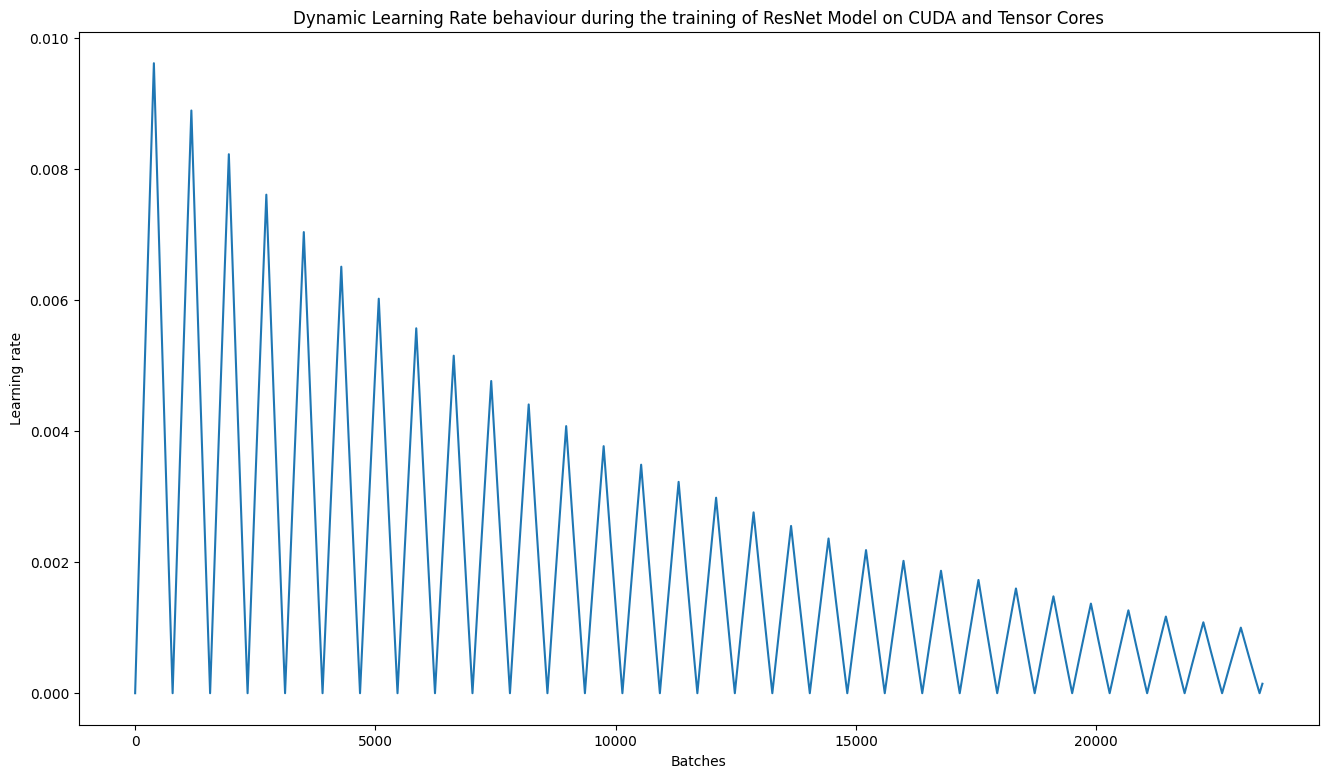

In [15]:
fig, ax = plt.subplots(figsize=(16,9))
plt.title('Dynamic Learning Rate behaviour during the training of ResNet Model on CUDA and Tensor Cores')
plt.plot(range(len(lr_tracker)), lr_tracker.values())
plt.xlabel('Batches')
plt.ylabel('Learning rate')
plt.savefig("Dynamic_LR_Mixed.png", format="png", dpi=300)
plt.show()

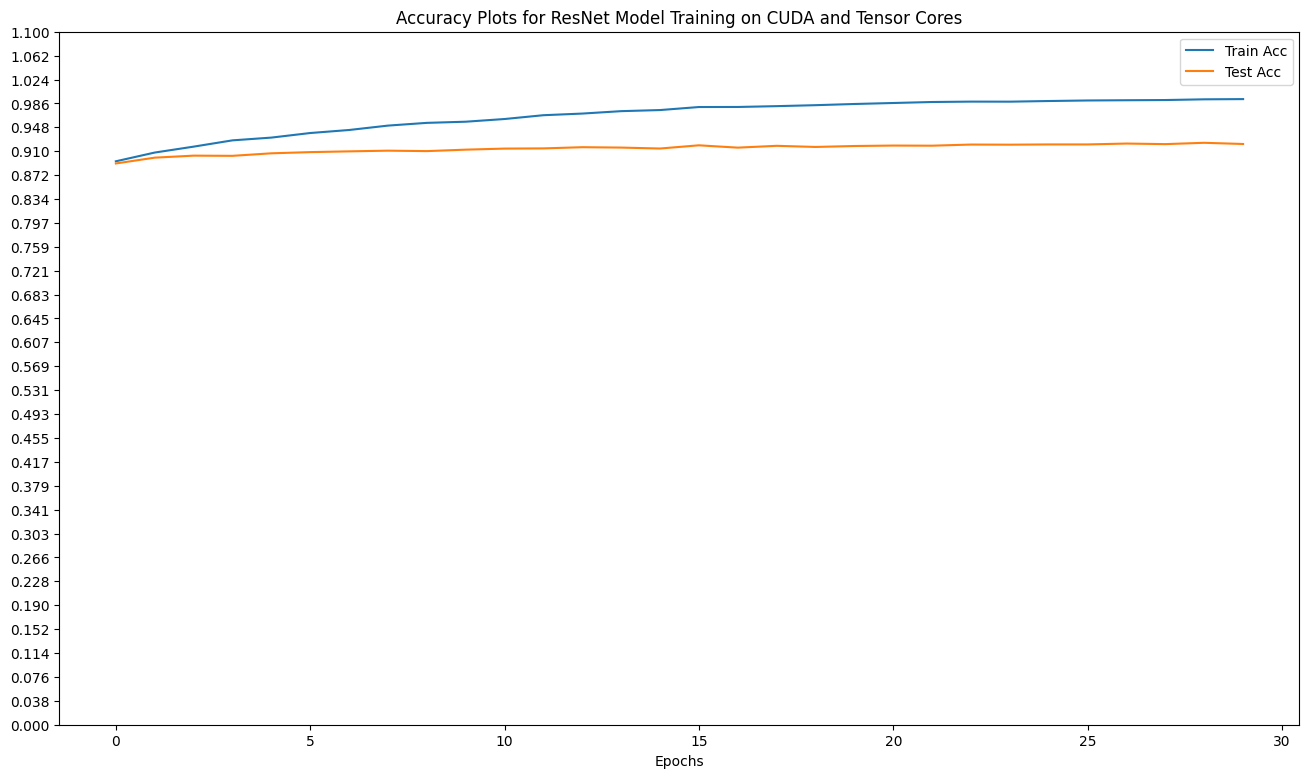

In [16]:
fig, ax = plt.subplots(figsize=(16,9))

plt.title('Accuracy Plots for ResNet Model Training on CUDA and Tensor Cores')
plt.plot(train_acc_history_tensor, label='Train Acc')  
plt.plot(val_acc_history_tensor, label='Test Acc')
plt.legend()
plt.xlabel("Epochs")
yticks = np.linspace(0, 1.1, num=30)
ax.set_yticks(yticks)
plt.savefig("Accuracy_Mixed.png", format="png", dpi=300)
plt.show()  

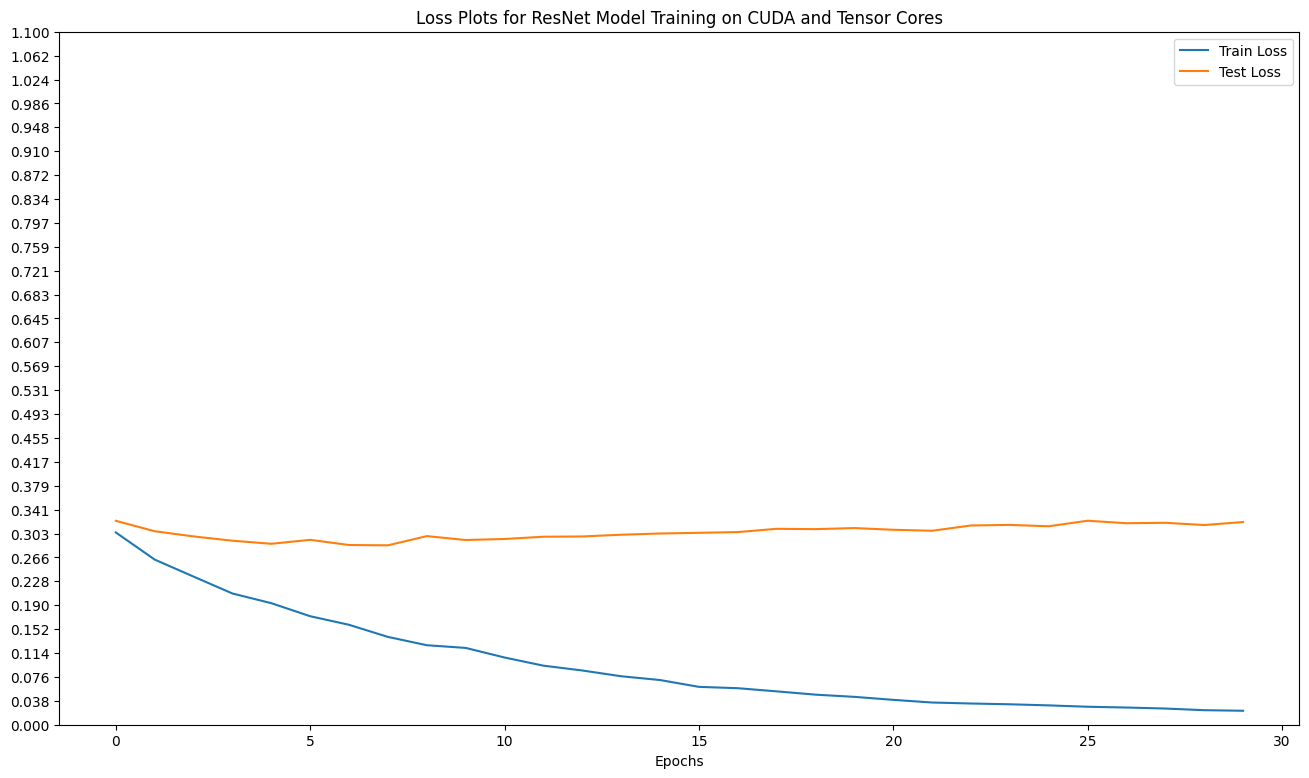

In [17]:
fig, ax = plt.subplots(figsize=(16,9))

plt.title('Loss Plots for ResNet Model Training on CUDA and Tensor Cores')
plt.plot(train_loss_history_tensor, label='Train Loss')
plt.plot(val_loss_history_tensor, label='Test Loss')
plt.legend()
plt.xlabel("Epochs")
yticks = np.linspace(0, 1.1, num=30)
ax.set_yticks(yticks)
plt.savefig("Loss_Mixed.png", format="png", dpi=300)
plt.show()  

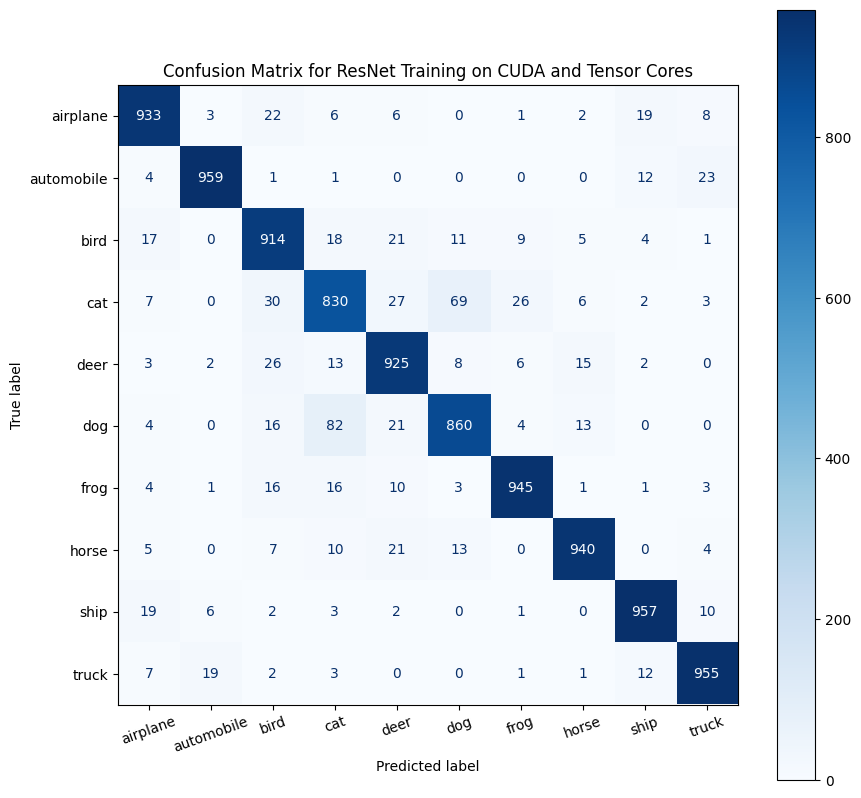

In [18]:
cm = confusion_matrix(y_true_tensor, y_pred_tensor)
fig = plt.figure(figsize = (10, 10));
ax = fig.add_subplot(1, 1, 1);
ax.set_title('Confusion Matrix for ResNet Training on CUDA and Tensor Cores')
cm = ConfusionMatrixDisplay(cm, display_labels = classes);
cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
plt.xticks(rotation = 20)
plt.savefig("Confusion_CUDA.png", format="png", dpi=300)
plt.show()  